### CAP 6640 
### Script Assignment 2
### Feb 15, 2024

### Group 4
### Andres Graterol
###                   UCF ID: 4031393
### Zachary Lyons
###                   UCF ID: 4226832
### Christopher Hinkle
###                   UCF ID: 4038573
### Nicolas Leocadio
###                   UCF ID: 3791733

We start by reading our corpus data, which is a list of tech news articles found from kaggle

https://www.kaggle.com/datasets/jeet2016/us-financial-news-articles

There is a requirements.txt file with all the needed python modules, "pip install -r requirements.txt"

Old: Prior to running, download corpus from top right of link and then extract to a folder called "archive" in the same directory as this file
New: Extract archive.zip (it's 1.89GB) to ./archive_usfinancial


------------- ./ScriptAssignment2.ipynb

------------- ./archive_usfinancial/*

In [129]:
import os
import json
import nltk
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')  # one time execution if not cached yet
nltk.download('stopwords')  # one time execution if not cached yet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Data Collection & Information Extraction

In [130]:
def read_data(archives_dir):
    corpus = []
    counter = 0
    # os.walk gets all the folders and paths in given directory
    for root, dirs, files in os.walk(archives_dir):
        for i, file in enumerate(files):
            # join path(root) and filename so that this can be computer-independent as long as names are the same
            # open in readonly mode, need encoding and ignore errors for weird characters in docs
            with open(os.path.join(root, file), 'r', encoding="utf8", errors='ignore') as f:
                # load json, can use strings for index from json tree
                # if data you want is inside of some structure, can use index like ['test1']['title']
                # https://devqa.io/python-parse-json/
                
                data = json.load(f)
                appendme = data['title'] + " " + data['published'] + " " + data['text'] # Create string with title, publish date, and document text
                
                if appendme: # Make sure not empty string
                    corpus.append((appendme))
            
            # This is here to only go through a few documents instead of the 2GB of documents
            # Leave in place to speed up testing/debug
            counter += 1
            if counter > 10000: # Break because a lot of documents
                return corpus
            
# Extracted the articles into folder called "archive_usfinancial", change as needed
# read_data() will parse through all folders/files inside there

######################################################
########### WARNING: There are a lot of files in there and it took an hour and a half to extract on my desktop
######################################################
corpus = read_data(os.getcwd() + "\\archive_usfinancial")

In [131]:
# Tokenzie
def tokenize(corpus):
    regex = re.compile('[^a-zA-Z0-9]')  # regex to only match alphanumeric characters
    tokens = []
    
    for sent in nltk.sent_tokenize(corpus):
        for word in nltk.word_tokenize(sent):
            clean_word = regex.sub('', word)
            if clean_word:  # make sure we're not appending empty strings
                tokens.append(clean_word.lower())
    return tokens

tokens = tokenize(corpus[0])
tokens[50:60]

['the',
 'emerging',
 'market',
 'etf',
 'eem',
 'was',
 'a',
 'weak',
 'dollar',
 'and']

In [132]:
# Remove stop words
def remove_stopwords(tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords]

no_stopwords = remove_stopwords(tokens)
no_stopwords[50:60]

['charts',
 'dollartracking',
 'etf',
 'uup',
 'believes',
 'us',
 'currency',
 'continue',
 'help',
 'group']

In [133]:
# Stem words in tokenized data
stemmer = SnowballStemmer("english")

def stem_words(word):
    return stemmer.stem(word).strip()

stemmed = [stem_words(word) for word in no_stopwords]
stemmed[50:60]

['chart',
 'dollartrack',
 'etf',
 'uup',
 'believ',
 'us',
 'currenc',
 'continu',
 'help',
 'group']

#### Topic Modeling

In [134]:
# Here we're using TfidVectorizer to create a matrix for our model
tfidf = TfidfVectorizer(max_df=0.95, max_features=50000,
                        min_df=0.0, stop_words='english',
                        use_idf=True, tokenizer=tokenize,
                        preprocessor=stem_words, lowercase=True)

tfidf_matrix = tfidf.fit_transform(corpus)

In [135]:
# Testing our model to ensure it is working
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['25000', 'stocks', 'gold', 'zone', 'dow', 'rose', 'dollar', 'euro', 'index', 'percent']


Topic #1:
['people', 'year', 'nt', 'company', 'reuters', 'new', 'president', 'trump', 'said', 's']


Topic #2:
['opec', 'oil', 'wolff', 'unrest', 'iranian', 'trump', 'book', 'protests', 'bannon', 'iran']


Topic #3:
['tanker', 'missile', 'talks', 'korean', 'pyongyang', 'spd', 'kim', 'north', 'merkel', 'korea']


Topic #4:
['bitcoin', 'million', 'ago', 'year', 'market', '2018', 'company', 'said', 'percent', 's']




[[0.02528564 0.02559288 0.02521522 0.02517626 0.89873   ]
 [0.03922955 0.04023226 0.03934203 0.03994929 0.84124687]
 [0.0227009  0.0233325  0.02266344 0.02262417 0.908679  ]
 ...
 [0.01537808 0.01596306 0.01540069 0.01530339 0.93795478]
 [0.02347649 0.02420705 0.02340529 0.02421493 0.90469624]
 [0.02693241 0.22431651 0.02623422 0.02612589 0.69639096]]
[4 4 4 ... 4 4 4]
Document number:  10001
Topic number:  5
10001
Topic Counts:  Counter({1: 4787, 4: 4685, 2: 305, 0: 198, 3: 26})


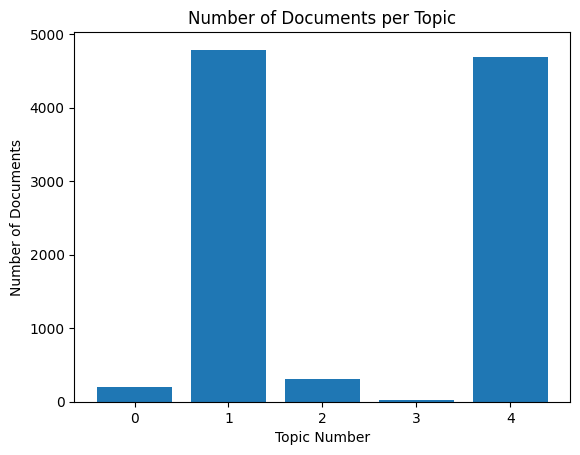

In [136]:
'''
    Returns a bar plot showing the distribution of documents among topics
'''
def topic_bar_plot(document_topics):
    # Obtain a dictionary that tells us in how many documents a topic was found in
    topic_counts = Counter(document_topics)
    print("Topic Counts: ", topic_counts)

    topics = topic_counts.keys()
    num_documents = topic_counts.values()

    plt.bar(topics, num_documents)
    plt.xlabel('Topic Number')
    plt.ylabel('Number of Documents')
    plt.title('Number of Documents per Topic')
    plt.show()


# Visualize the distribution of articles among the topics 
topic_values = lda.transform(tfidf_matrix)
print(topic_values)

# Get the most well-represented topic for each document
document_topics = topic_values.argmax(axis=1)
print(document_topics)

doc_num, topic_num = topic_values.shape

print("Document number: ", doc_num)
print("Topic number: ", topic_num)
print(len(topic_values))

topic_bar_plot(document_topics)

In [137]:
# Since we're using sklearns model for LDA and not gensim's we're using perplexity score to determine the optimal number of topics
# Perplexity score measures how well a model can predict a sample, a lower score represents higher certainty
perplexity_scores = []
for num_topics in range(1, 10):
    # Creating a new model for each num_topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)
    perplexity = lda.perplexity(tfidf_matrix)
    perplexity_scores.append(perplexity)
# after getting all of our perplexity scores we grab the index with the lowest score and use that as our num_topics
optimal_num_topics = perplexity_scores.index(min(perplexity_scores)) + 1
print("Optimal number of topics:", optimal_num_topics)

Optimal number of topics: 1


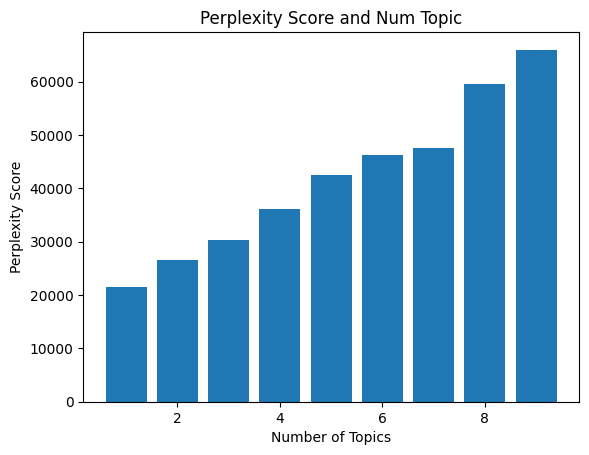

In [138]:
plt.bar(range(1,10), perplexity_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Score and Num Topic')
plt.show()

In [139]:
# We can clearly see in our case, that having less number of topics is clearly better for our model and our optimal output is 1
optimal_num_topics = perplexity_scores.index(min(perplexity_scores)) + 1
print("Optimal number of topics:", optimal_num_topics)

Optimal number of topics: 1


In [140]:
lda = LatentDirichletAllocation(n_components=1, random_state=42)
lda.fit(tfidf_matrix)

for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['2017', '2018', 'reuters', 'year', 'new', 'company', 'trump', 'percent', 'said', 's']




#### Analysis

Based on the perplexity graph, our model is the most confident when the number of topics is one. If we're to analyze only 1 topic we can assume that the documents have to do with banking under the trump presidency during the years 2017 and 2018.
This however isn't interesting so let's test using 3 topics as to not increase the perplexity score too much.

In [141]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(tfidf_matrix)

for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['rose', 'inflation', 'markets', 'euro', 'fed', 'stocks', 'index', 'dow', 'dollar', 'percent']


Topic #1:
['million', '2018', 'reuters', 'year', 'percent', 'trump', 'new', 'company', 'said', 's']


Topic #2:
['killed', 'unrest', 'police', 'book', 'iranian', 'pakistan', 'trump', 'protests', 'bannon', 'iran']




Topic #0 appears to be about the value of currency in the current market, particularly about inflation rising

Topic #1 is about what I said previously, Economy under trump presidency

Topic #2 takes a shift from the economy and discusses tension and unrest during the trump presidency, particularly in the middle east